# Federated 2d XRay registration with MONAI

## Introduction

This tutorial shows how to deploy in Fed-BioMed the 2d image registration example provided in the project MONAI (https://monai.io/):

https://github.com/Project-MONAI/tutorials/blob/master/2d_registration/registration_mednist.ipynb

Being MONAI based on PyTorch, the deployment within Fed-BioMed follows seamlessly the same general structure of general PyTorch training plans.

Following the MONAI example, this tutorial is based on the MedNIST dataset>



## Image Registration

Image registration is the process of transforming and recalibrating different images into one coordinate system. It makes possible to compare several images captured with the same modality.

In this tutorial, we are using a UNet-like registration network ( https://arxiv.org/abs/1711.01666 ).
Goal of the notebook is to train a model given moving images and fixed images (recalibrated images). 

## Creating MedNIST nodes

MedNIST provides an artificial 2d classification dataset created by gathering different medical imaging datasets from TCIA, the RSNA Bone Age Challenge, and the NIH Chest X-ray dataset. The dataset is kindly made available by Dr. Bradley J. Erickson M.D., Ph.D. (Department of Radiology, Mayo Clinic) under the Creative Commons CC BY-SA 4.0 license.

To proceed with the tutorial, we created an iid partitioning of the MedNIST dataset between 3 clients. Each client has 3000 image samples for each class. The training partitions are availables at the following link:

https://drive.google.com/file/d/1vLIcBdtdAhh6K-vrgCFy_0Y55dxOWZwf/view

The dataset owned by each client has structure:


└── client_*/

    ├── AbdomenCT/
    
    └── BreastMRI/
    
    └── CXR/
    
    └── ChestCT/
    
    └── Hand/
    
    └── HeadCT/      

To create the federated dataset, we follow the standard procedure for node creation/population of Fed-BioMed. 

we use the environment where Fed-BioMed node is installed

we create a first node by using the commands

`fedbiomed node start`

We then populate the node with the data of first client:

`fedbiomed node dataset add`

We select option 3 (images) to add MedNIST partition of client 1, by just picking the folder of client 1. We use `mednist` as tag to save the selected dataset.
We can further check that the data has been added by executing `fedbiomed node dataset list`

Following the same procedure, we create the other two nodes with the datasets of client 2 and client 3 respectively.


## Running Fed-BioMed Researcher

We are now ready to start the researcher by using the environment where Fed-BioMed researcher is installed, and open the Jupyter notebook with `fedbiomed researcher start`.

We can first query the network for the `Mednist` dataset. In this case, the nodes are sharing the respective partitions using the same tag `mednist`:

In [ ]:
from fedbiomed.researcher.requests import Requests
from fedbiomed.researcher.config import config
req = Requests(config)
req.list(verbose=True)

## Create an experiment to train a model on the data found

The code for network and data loader of the MONAI tutorial can now be deployed in Fed-BioMed.
We first import the necessary modules from `fedbiomed` and `monai` libraries:

We can now define the training plan. Unlike the previous MONAI tutorial, here we use a specific Fedbiomed class called the `CustomDataset`, which works as a wrapper for any non-Fedbiomed dataset that you want to use. It works by overriding two methods:

- The `read` method, where we define how we read the dataset from the file/folder.
- The `get_item` method, where we define how we get a single sample from the dataset, in the form of (data, target).

In the `read` method we can use `self.path`, which is the location where we added the dataset in the node in the previous step. It saves us from writing the whole path again for the dataset. 

We can apply the preprocessing/transformations on either the read step, or in the get_item step before we return the item. In the `training_data` function, we just give our `CustomDataset` to the `DataManager` class as a parameter.

We use the GlobalNet model from MONAI, with Adam Optimizer. For the loss, we use MSE loss.

In [ ]:
import numpy as np
import torch
import torch.nn as nn
from torch.nn.functional import mse_loss
from torch.utils.data import DataLoader
from fedbiomed.common.training_plans import TorchTrainingPlan
from fedbiomed.common.logger import logger
from fedbiomed.common.datamanager import DataManager
import monai
from monai.utils import set_determinism, first
from monai.transforms import (
    EnsureChannelFirstD,
    Compose,
    LoadImageD,
    RandRotateD,
    RandZoomD,
    ScaleIntensityRanged,
    EnsureTypeD,
)
from monai.data import DataLoader, Dataset, CacheDataset, PILReader
from monai.config import print_config, USE_COMPILED
from monai.networks.nets import GlobalNet
from monai.networks.blocks import Warp
from monai.apps import MedNISTDataset

from fedbiomed.common.dataset import CustomDataset


# Here we define the training plan to be used. 
class MyMonaiTrainingPlan(TorchTrainingPlan):
    def init_model(self, model_args = None):
        model_= GlobalNet(
            image_size=(64, 64),
            spatial_dims=2,
            in_channels=2,  # moving and fixed
            num_channel_initial=16,
            depth=3)

        if USE_COMPILED:
            model_.warp_layer = Warp(3, "border")
        else:
            model_.warp_layer = Warp("bilinear", "border")

        return model_

    def init_dependencies(self):
        return ["import numpy as np",
                "import os",
                "import monai",
                "from torch.nn.functional import mse_loss",
                "from monai.utils import set_determinism, first",
                "from monai.transforms import (EnsureChannelFirstD,Compose,LoadImageD,RandRotateD,RandZoomD,ScaleIntensityRanged,EnsureTypeD,)",
                "from monai.data import DataLoader, Dataset, CacheDataset, PILReader",
                "from monai.networks.nets import GlobalNet",
                "from monai.config import USE_COMPILED",
                "from monai.networks.blocks import Warp",
                "from monai.apps import MedNISTDataset",
                "from fedbiomed.common.dataset import CustomDataset",
                "from fedbiomed.researcher.config import config",
                "from fedbiomed.common.logger import logger",]

    def init_optimizer(self, optimizer_args):
        lr = optimizer_args.get('lr', 1e-5)
        return torch.optim.Adam(self.model().parameters(), lr)

    class MyMednistDataset(CustomDataset):
        def read(self):
            data_path = self.path # self.path keeps the location of the selected dataset via the tag

            # The following line is needed if client structure does not contain the "/MedNIST" folder
            # MedNISTDataset.dataset_folder_name = ""

            train_data = MedNISTDataset(root_dir=data_path, section="training", download=True, transform=None)
            training_datadict = [
                {"fixed_hand": item["image"], "moving_hand": item["image"]}
                for item in train_data.data if item["label"] == 4  # label 4 is for xray hands
            ]
            train_transforms = Compose(
                [
                    LoadImageD(keys=["fixed_hand", "moving_hand"], reader=PILReader()),
                    EnsureChannelFirstD(keys=["fixed_hand", "moving_hand"]),
                    ScaleIntensityRanged(keys=["fixed_hand", "moving_hand"],
                                         a_min=0., a_max=255., b_min=0.0, b_max=1.0, clip=True,),
                    RandRotateD(keys=["moving_hand"], range_x=np.pi/4, prob=1.0, keep_size=True, mode="bicubic"),
                    RandZoomD(keys=["moving_hand"], min_zoom=0.9, max_zoom=1.1,
                              monaiprob=1.0, mode="bicubic", align_corners=False),
                    EnsureTypeD(keys=["fixed_hand", "moving_hand"]),
                ]
            )
            self.dataset = CacheDataset(data=training_datadict[:1000], transform=train_transforms, cache_rate=1.0, num_workers=0)

        def get_item(self, idx):
            return (self.dataset[idx]["moving_hand"], self.dataset[idx]["fixed_hand"])

        def __len__(self):
            return len(self.dataset)
            
    def training_data(self):
        return DataManager(self.MyMednistDataset(), shuffle=True, num_workers=0)

    def training_step(self, moving, fixed):
        ddf = self.model().forward(torch.cat((moving, fixed), dim=1))
        pred_image = self.model().warp_layer(moving, ddf)
        loss = mse_loss(pred_image, fixed)
        return loss

We now set the model and training parameters. Note that in this case, no model argument is required.

In [ ]:
model_args = {}

training_args = {
    'loader_args': { 'batch_size': 16, },
    'epochs': 3,
    'dry_run': False,  
    'batch_maxnum':250, # Fast pass for development : only use ( batch_maxnum * batch_size ) samples
    'optimizer_args': {
        'lr': 1e-5,
    },
    'use_gpu': True # Training on GPU
}

The experiment can be now defined, by providing the `mednist` tag, and running the local training on nodes with training plan defined in `training_plan_path`, standard `aggregator` (FedAvg) and `client_selection_strategy` (all nodes used). Federated learning is going to be performed through 5 optimization rounds.

In [ ]:
from fedbiomed.researcher.federated_workflows import Experiment
from fedbiomed.researcher.aggregators.fedavg import FedAverage

tags =  ['#MEDNIST']
rounds = 5

exp = Experiment(tags=tags,
                 model_args=model_args,
                 training_plan_class=MyMonaiTrainingPlan,
                 training_args=training_args,
                 round_limit=rounds,
                 aggregator=FedAverage(),
                 node_selection_strategy=None
                )

Let's start the experiment.

By default, this function doesn't stop until all the `round_limit` rounds are done for all the clients

In [ ]:
exp.run()

Save trained model to file

In [ ]:
exp.training_plan().export_model('./trained_model')

## Testing


Once the federated model is obtained, it is possible to test it locally on an independent testing partition.
The test dataset is available at this link:

https://drive.google.com/file/d/1YbwA0WitMoucoIa_Qao7IC1haPfDp-XD/

Following the Monai tutorial, in this section we will create a set of previously unseen pairs of moving vs fixed hands, and use the final federated model to predict the transformation between each pair.

In [ ]:
!pip install matplotlib
!pip install gdown

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt


print_config()
set_determinism(42)

Download the testing dataset on the local temporary folder.

In [ ]:
import gdown
import zipfile
import tempfile
import os

from fedbiomed.researcher.config import config

tmp_dir = tempfile.TemporaryDirectory(dir=config.vars['TMP_DIR']+os.sep)

resource = "https://drive.google.com/uc?id=1YbwA0WitMoucoIa_Qao7IC1haPfDp-XD"
base_dir = tmp_dir.name
test_file = os.path.join(base_dir, "MedNIST_testing.zip")

gdown.download(resource, test_file, quiet=False)

zf = zipfile.ZipFile(test_file)

for file in zf.infolist():
    zf.extract(file, base_dir)
    
data_dir = os.path.join(base_dir, "MedNIST_testing")

Create the Custom Dataset class and pairs of moving vs fixed hands:

In [ ]:
# Use a GPU if you have one + enough memory available
#
#use_cuda = torch.cuda.is_available()
#device = torch.device("cuda:0" if use_cuda else "cpu")
device = 'cpu'

# recreate model
model = GlobalNet(
    image_size=(64, 64),
    spatial_dims=2,
    in_channels=2,  # moving and fixed
    num_channel_initial=16,
    depth=3).to(device)

if USE_COMPILED:
    warp_layer = Warp(3, "border").to(device)
else:
    warp_layer = Warp("bilinear", "border").to(device)

test_dataset = exp.training_plan().MyMednistDataset()
test_dataset.path = data_dir
test_dataset.read()

val_loader = DataLoader(test_dataset, batch_size=16, num_workers=0)

Create a model instance and assign to it the model parameters estimated at the last federated optimization round.
Generate predictions of the transformation between pairs.

In [ ]:
# extract federated model into PyTorch framework
model = exp.training_plan().model()
model.load_state_dict(exp.aggregated_params()[rounds - 1]['params'])

batch_size = 10
test_loader = DataLoader(test_dataset.dataset, batch_size=batch_size, shuffle=False)

for batch in test_loader:
    moving = batch["moving_hand"].to(device).float()   # (B, C, H, W)
    fixed  = batch["fixed_hand"].to(device).float()    # (B, C, H, W)

    x = torch.cat([moving, fixed], dim=1)              # (B, 2C, H, W)
    ddf = model(x)                                     # predict deformation
    pred_image = warp_layer(moving, ddf)               # warp moving → fixed
    break

fixed_image = fixed.detach().cpu().numpy()[:, 0]
moving_image = moving.detach().cpu().numpy()[:, 0]
pred_image = pred_image.detach().cpu().numpy()[:, 0]

We can finally print some example of predictions from the testing dataset.

In [ ]:
%matplotlib inline

plt.subplots(batch_size, 4, figsize=(12, 20))
for b in range(batch_size):
    # moving image
    plt.subplot(batch_size, 4, b * 4 + 1)
    plt.axis('off')
    plt.title("moving image")
    plt.imshow(moving_image[b], cmap="gray")
    # fixed image
    plt.subplot(batch_size, 4, b * 4 + 2)
    plt.axis('off')
    plt.title("fixed image")
    plt.imshow(fixed_image[b], cmap="gray")
    # warped moving
    plt.subplot(batch_size, 4, b * 4 + 3)
    plt.axis('off')
    plt.title("predicted image")
    plt.imshow(pred_image[b], cmap="gray")
    
    #error
    plt.subplot(batch_size, 4, b * 4 + 4)
    plt.axis('off')
    plt.title("error between predicted \nand fixed image")
    plt.imshow(pred_image[b] - fixed_image[b], cmap="gray")
plt.axis('off')
plt.show()

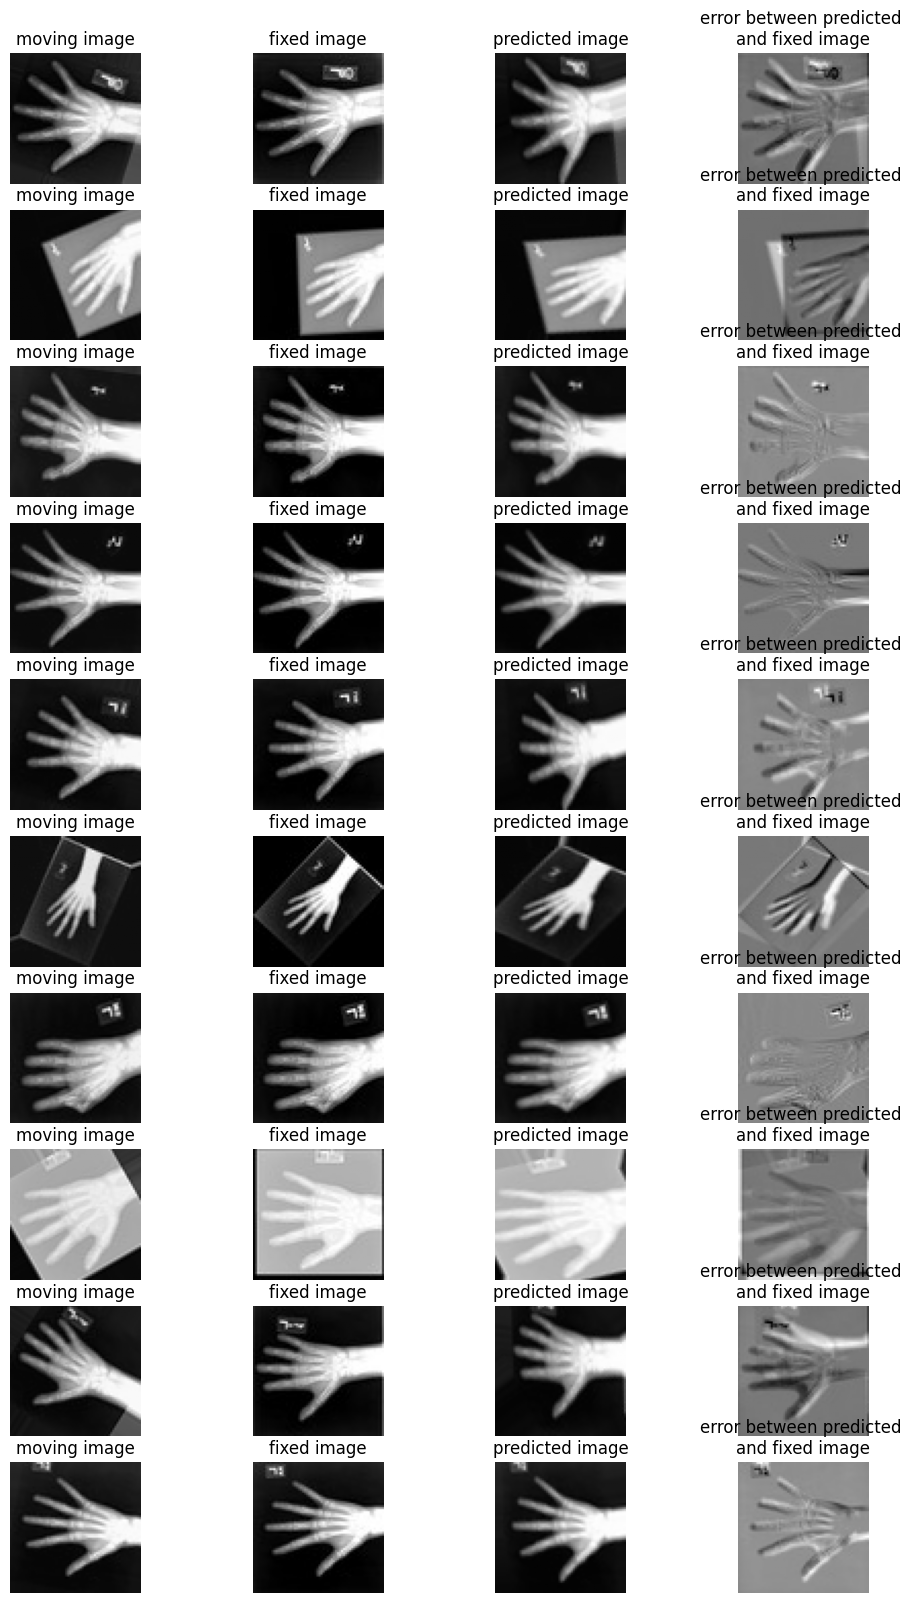